# Amazon Alexa Sentiment Analysis

In [142]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from spacy import displacy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, average_precision_score
#import en_core_web_sm


In [150]:
#reading file
df=pd.read_csv("amazon_alexa.tsv",sep="\t")
type(df['date'])

pandas.core.series.Series

### Exploratory Data Analysis

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
rating              3150 non-null int64
date                3150 non-null object
variation           3150 non-null object
verified_reviews    3150 non-null object
feedback            3150 non-null int64
dtypes: int64(2), object(3)
memory usage: 123.1+ KB


In [70]:
df.shape


(3150, 5)

In [71]:
df.describe()


,rating,feedback
count,3150.000000,3150.000000
mean,4.463175,0.918413
std,1.068506,0.273778
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


In [72]:
df.isna().mean(axis=0)

rating              0.0
date                0.0
variation           0.0
verified_reviews    0.0
feedback            0.0
dtype: float64

In [95]:
df['feedback'].value_counts()

1    2893
0     257
Name: feedback, dtype: int64

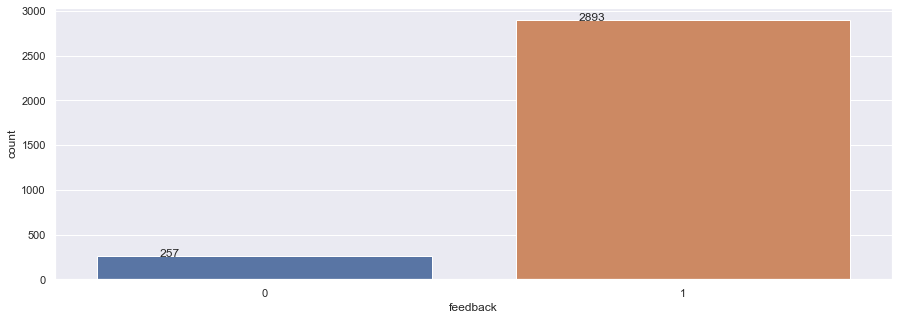

In [73]:
plt.figure(figsize=(15,5))
ax=sns.countplot(data=df,x='feedback');
#for p, label in zip(ax.patches, df["feedback"].value_counts().index):
 #   ax.annotate(label, (p.get_x()+0.375, p.get_height()+0.15))
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

In [74]:
df['feedback'].mean()

0.9184126984126985

91% of the data has positive reviews

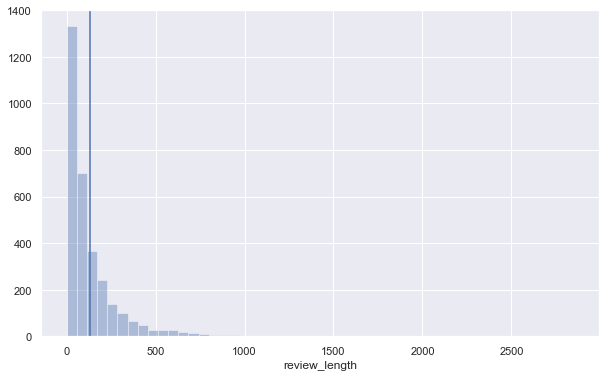

In [75]:
#seeing the distribution of word length
df['review_length']=df['verified_reviews'].apply(len)

fig = plt.figure(1, figsize=(10,6))
sns.distplot(df['review_length'],kde=False);
plt.axvline(x=df['review_length'].mean(), ymin=0,ymax=1);

In [76]:
df['review_length'].mean()

132.0495238095238

Avergae review length is around 132 words.

In [77]:
df['date']=pd.to_datetime(df['date'], format="%d-%b-%y")
df.dtypes

rating                       int64
date                datetime64[ns]
variation                   object
verified_reviews            object
feedback                     int64
review_length                int64
dtype: object

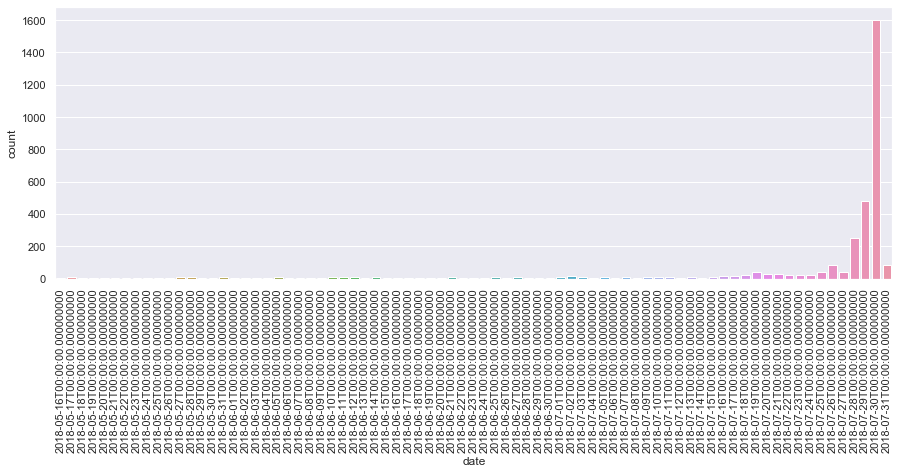

In [78]:
plt.figure(figsize=(15,5))
ax=sns.countplot(df['date'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);


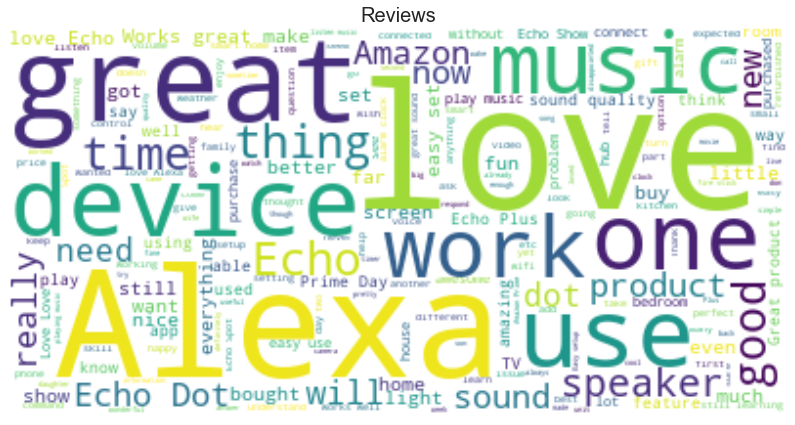

In [79]:
np.random.seed(10)
sns.set(rc={'figure.figsize':(14,8)})
reviews = ' '.join(df['verified_reviews'].tolist())

wordcloud = WordCloud(background_color="white").generate(reviews)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Reviews',size=20)
plt.show()

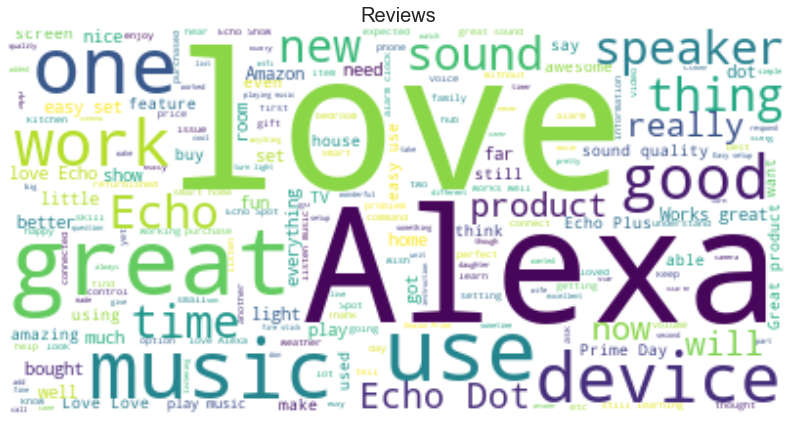

In [80]:
df_positive=df[df['feedback']==1]
sns.set(rc={'figure.figsize':(14,8)})
reviews = ' '.join(df_positive['verified_reviews'].tolist())

wordcloud = WordCloud(background_color="white").generate(reviews)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Reviews',size=20)
plt.show()

Mostly contains words such as alexa, love,music,one,speaker,good,device,great

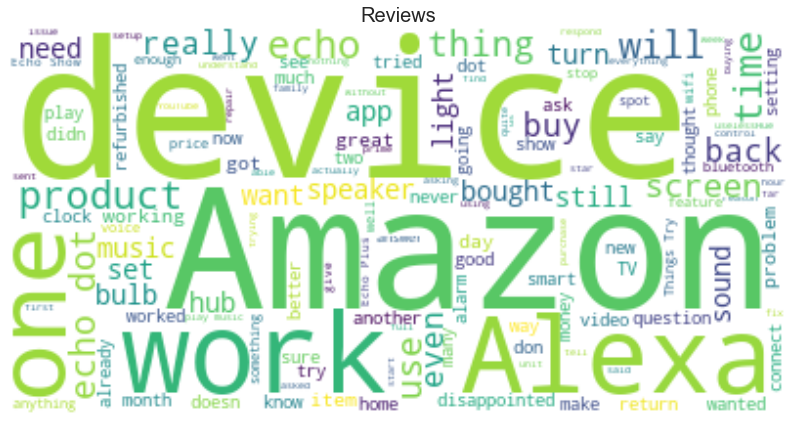

In [81]:
df_negative=df[df['feedback']==0]
sns.set(rc={'figure.figsize':(14,8)})
reviews = ' '.join(df_negative['verified_reviews'].tolist())

wordcloud = WordCloud(background_color="white").generate(reviews)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Reviews',size=20)
plt.show()

Contains words like never,disappointed,tried,problem,still.

### Tokenizing data with Spacy

Let's create a custom function using spacy which will automatically strip words that we dont need. Few of these words include stopwords, punctuations, special characters.

### Using BOW
#### Tokenization

In [96]:
punctuations = string.punctuation
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS
parser = English()

In [109]:
def data_cleaning(sentence):
    doc = nlp(sentence)
    
    tokens = []
    for token in doc:
        if token.lemma_!='-PRON-':
            temp=token.lemma_.lower().strip()
        else:
            temp=token.lower_
        tokens.append(temp)
            
    cleaned_tokens=[]
    for token in tokens:
        if token not in stop_words and token not in punctuations:
            cleaned_tokens.append(token)
    
    return cleaned_tokens
            
    
    

 ### Vectorization Feature Engineering (TF-IDF):

In [110]:
from sklearn.svm import LinearSVC

In [132]:
tfidf_vector = TfidfVectorizer(tokenizer = data_cleaning,ngram_range=(1,2))

In [133]:
classifier=LinearSVC()
X=df['verified_reviews']
y=df['feedback']

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [135]:
pipe = Pipeline([('tfidf', tfidf_vector),
                 ('clf', classifier)])

In [136]:
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function data_cleaning at 0x0000014F0DC35B70>,
                                 use_idf=True, vocabulary=None)),
                ('clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=

In [137]:
predicted = pipe.predict(X_test)

In [138]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.88      0.30      0.45        76
           1       0.94      1.00      0.97       869

    accuracy                           0.94       945
   macro avg       0.91      0.65      0.71       945
weighted avg       0.94      0.94      0.93       945



In [119]:
confusion_matrix(y_test,predicted)

array([[ 27,  49],
       [  6, 863]], dtype=int64)

In [131]:
pipe.predict(['return'])

array([0], dtype=int64)

In [141]:
X_test

1369    Thank God, and alarm clock with an lcd that ge...
1882    The Echoplus is a great extension for the Echo...
2422    The installation and connection to my Wi-Fi wa...
1126    With the combination of this, smart plugins, a...
1767    We love our Echo Plus. We like listening to mu...
764     I love my Echo!  Works just like they said it ...
372                                              It works
1455    Great item for knowledge, directions, music,la...
25                                        Amazing product
404     Bought this for the guest room.  It's a radio,...
1286                                    Husband loves it!
56      Works as advertised. Very easy to setup. Still...
1683                       Clear screen and great picture
1476    I already had purchased the Echo and a couple ...
2108                                       It works great
2251    I don't have Alexa, but after getting this I'm...
2671                                        Better sound.
3049    I had 